# Notebook Overview
The objective of this notebook is to explore historical avalanche danger ratings as reported by Avalanche Canada (https://www.avalanche.ca/). Specifically, this notebook attempts to assess anomalies between day of danger ratings and one- and two-day out forecasted danger ratings. 

#### Notebook Outline
A basic outline for the notebook is as follows:
1. Load data
3. Explore Data - visualize danger rating data
4. Data Analysis - assess forecasted danger rating anomalies

#### The Data
The dataset is created with scrape_export_data.py and cleaned with clean_scraped_data.py. Data includes day of and 1- and 2-day out forecasted danger ratings. Additionally, any snowpack problems, as written by the forecaster, are included for day of danger ratings.

#### Key Terms
A few key terms that are important to understand in this analysis:
* Day of Conditions - The current days avalanche danger ratings. This is the most up to date condition forecast.
* Day of Conditions Plus 1 and 2 - Tomorrow and the day after tomorrows forecasted danger ratings. These are always superceded by the Day of Conditions.
* Avalanche Status Code - Avalanche danger ratings on a scale of 1-5 with 5 being Extreme and 1 being Low
* Alpine - Elevations above treeline
* Treeline - Elevations at or near treeline
* Below Treeline - Elevations in the trees
* Forecast Anamoly - Difference between forecasted value and observed/reported value.

#### Getting Started
1. In the Load Data section define the filenames of the cleaned dataset to analyze and visualize
2. Run all cells, figures are exported to figure folder

## Library Imports

In [10]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from collections import Counter

## Helper Functions

In [11]:
# helper functions
def zero_matrix():
    '''function to create a zero matrix for seaborn heatmap plotting'''
    
    df = pd.DataFrame(np.zeros((5,5)), index=[5,4,3,2,1])  # reverse for plotting purposes
    df.columns = [1,2,3,4,5]
    
    return df

## Load Dataset

In [12]:
# define absolute path to cleaned data folder
raw_data_root_path = os.path.abspath('../data/cleaned')

# cleaned data filenames - CHANGE THIS TO MATCH THE FILES YOU WANT TO SHOW
current_conditions_file = 'current_avalanche_danger_ratings_sea_to_sky_CLEANED.csv'  
current_plus1_conditions_file = 'current_plus1_avalanche_danger_ratings_sea_to_sky_CLEANED.csv' 
current_plus2_conditions_file = 'current_plus2_avalanche_danger_ratings_sea_to_sky_CLEANED.csv'  
  
# define absolute path to cleaned data files
current_conditions_path = os.path.join(raw_data_root_path, current_conditions_file)
current_plus1_conditions_path = os.path.join(raw_data_root_path, current_plus1_conditions_file)
current_plus2_conditions_path = os.path.join(raw_data_root_path, current_plus2_conditions_file) 

# load raw data to dataframe, parse dates as datetime
df_cleaned_current = pd.read_csv(current_conditions_path, parse_dates=['date_valid'])
df_cleaned_current_plus1 = pd.read_csv(current_plus1_conditions_path, parse_dates=['date_valid'])
df_cleaned_current_plus2 = pd.read_csv(current_plus2_conditions_path, parse_dates=['date_valid'])

## Explore Data

#### Custom Colormap

In [13]:
colors = [(82/255, 186/255, 74/255), (255/255, 243/255, 0/255), (247/255, 146/255, 24/255), 
          (239/255, 28/255, 41/255), (0/255, 0/255, 0/255)]

#### Visualization of "Day of Conditions" in Sea to Sky Region 2011-2020

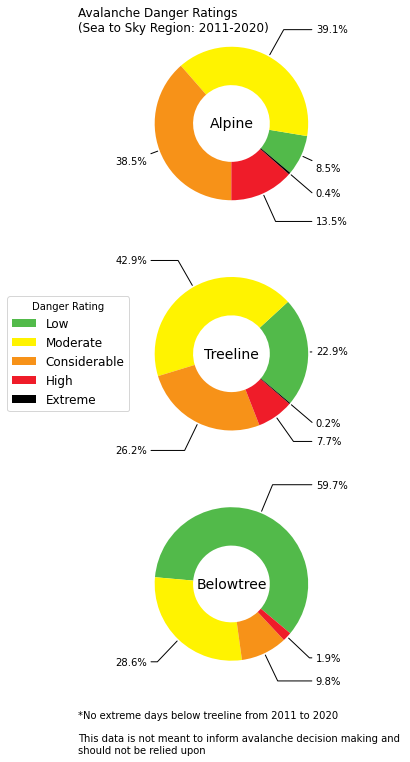

In [112]:
# percent occurence of each avalanche condition for each elevation
avy_perc_occur_alpine = df_cleaned_current['alpine_status_code'].value_counts(normalize=True) * 100
avy_perc_occur_treeline = df_cleaned_current['treeline_status_code'].value_counts(normalize=True) * 100
avy_perc_occur_belowtree = df_cleaned_current['belowtree_status_code'].value_counts(normalize=True) * 100

# combine into one dataframe for plotting ease
avy_perc_occur_all_elev = pd.concat([avy_perc_occur_alpine, avy_perc_occur_treeline, avy_perc_occur_belowtree], axis=1)

# properties for donut charts
status_labels = ['Low', 'Moderate', 'Considerable', 'High', 'Extreme']
title_labels = ['Alpine', 'Treeline', 'Belowtree']

# create donut chart for each elevation
fig, ax = plt.subplots(3,1,figsize=(7,12), subplot_kw=dict(aspect="equal"), facecolor='white')

for i, col in enumerate(avy_perc_occur_all_elev):
    
    data = avy_perc_occur_all_elev[col]  # column of dataframe to render
    data.dropna(inplace=True)  # remove any NaN rows
        
    donut_labels = [str(round(y,1)) + '%' for y in list(data)]
            
    wedges, texts = ax[i].pie(data, wedgeprops=dict(width=0.5), startangle=-40, colors = colors)  # create donut chart
        
    #  create lines and labels
    kw = dict(arrowprops=dict(arrowstyle="-"), zorder=0, va="center")
    
    for j, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1  # a bit of 9th grade geometry
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax[i].annotate(donut_labels[j], xy=(x, y), xytext=(1.1*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)
        
    ax[i].text(0,0,title_labels[i], fontsize='14', ha='center', va='center')  # add title to donut center
    
    # overall title
    if i == 0:
        ax[i].text(-2,1.2,'Avalanche Danger Ratings \n(Sea to Sky Region: 2011-2020)', fontsize='12')
    
    # legend
    if i == 1:
        ax[i].legend(wedges, status_labels, title="Danger Rating", loc='center left', 
                     bbox_to_anchor=(-0.7, 0.25, 0.5, 0.5), prop=dict(size=12))
# notes about dataset       
ax[2].text(-2, -2.2, '*No extreme days below treeline from 2011 to 2020 \
\n\nThis data is not meant to inform avalanche decision making and \nshould not be relied upon')

plt.savefig('../figures/avalanche-danger-ratings-sea-to-sky-2011-2020.png')

#### Visualization of "Day of Conditions" by year

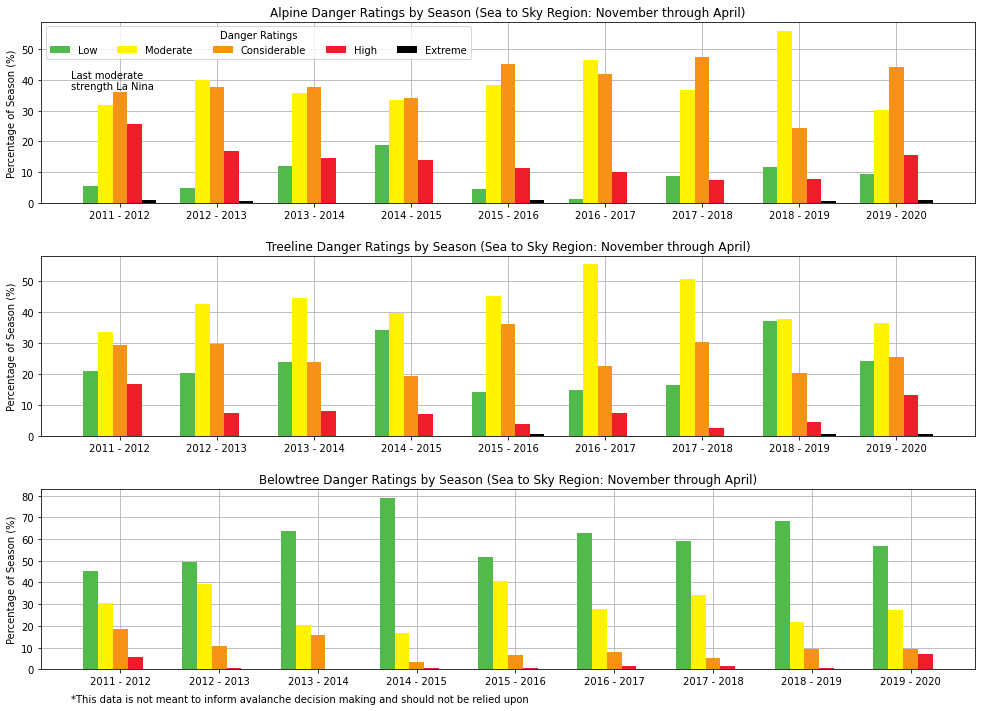

In [73]:
# list of years in dataset
years = df_cleaned_current.date_valid.dt.year.unique()

# initialize empty list
alpine_conditions = []
treeline_conditions = []
belowtree_conditions = []
year_labels = []

for i, year in enumerate(years[:-1]):
    
    # define avalanche season
    start = '{}-11-01'.format(year)
    end = '{}-05-01'.format(year+1)
        
    # create label for figure
    label = '{} - {}'.format(year, year+1)
    year_labels.append(label)
        
    # creates list of avalanche conditions for each season at each elevation
    alpine_conditions.append(df_cleaned_current[(df_cleaned_current.date_valid > start) & 
                                                (df_cleaned_current.date_valid < end)]['alpine_status_code'].value_counts(normalize=True) * 100)
   
    treeline_conditions.append(df_cleaned_current[(df_cleaned_current.date_valid > start) & 
                                                (df_cleaned_current.date_valid < end)]['treeline_status_code'].value_counts(normalize=True) * 100)
    
    belowtree_conditions.append(df_cleaned_current[(df_cleaned_current.date_valid > start) & 
                                                (df_cleaned_current.date_valid < end)]['belowtree_status_code'].value_counts(normalize=True) * 100)
    
# creates dataframes from lists
df_alpine = pd.DataFrame(alpine_conditions)
df_treeline = pd.DataFrame(treeline_conditions)
df_belowtree = pd.DataFrame(belowtree_conditions)
                                     
fig, ax = plt.subplots(3,1,figsize=(14,10), facecolor="white")

# define plot properties
title_label = ['Alpine', 'Treeline', 'Belowtree']
x = np.arange(len(alpine_conditions))
width = 0.15

# create bar charts
for i, df in enumerate([df_alpine, df_treeline, df_belowtree]):
    
    rects1 = ax[i].bar(x - width*2, df[1], width, label='Low', zorder=3, color=colors[0])
    rects2 = ax[i].bar(x - width, df[2], width, label='Moderate', zorder=3, color=colors[1])
    rects3 = ax[i].bar(x, df[3], width, label='Considerable', zorder=3, color=colors[2])
    rects4 = ax[i].bar(x + width, df[4], width, label='High', zorder=3, color=colors[3])
    
    if 5 in df.columns:
        rects5 = ax[i].bar(x + width*2, df[5], width, label='Extreme', zorder=3, color=colors[4])
        
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(year_labels)
    ax[i].set_title('{} Danger Ratings by Season (Sea to Sky Region: November through April)'.format(title_label[i]))
    ax[i].set_ylabel('Percentage of Season (%)')
    ax[i].grid(zorder=0)

# add legend and text
ax[0].legend(title="Danger Ratings", loc='center left', bbox_to_anchor=(0, 0.64, 0.5, 0.5), ncol=5)
ax[0].text(-0.5,37,'Last moderate \nstrength La Nina')

fig.tight_layout(pad=2)

ax[2].text(-0.5, -15, '*This data is not meant to inform avalanche decision making and should not be relied upon')

plt.savefig('../figures/avalanche-danger-ratings-by-season-sea-to-sky-2011-2020.png')

#### Visualization of "Day of Conditions" by month

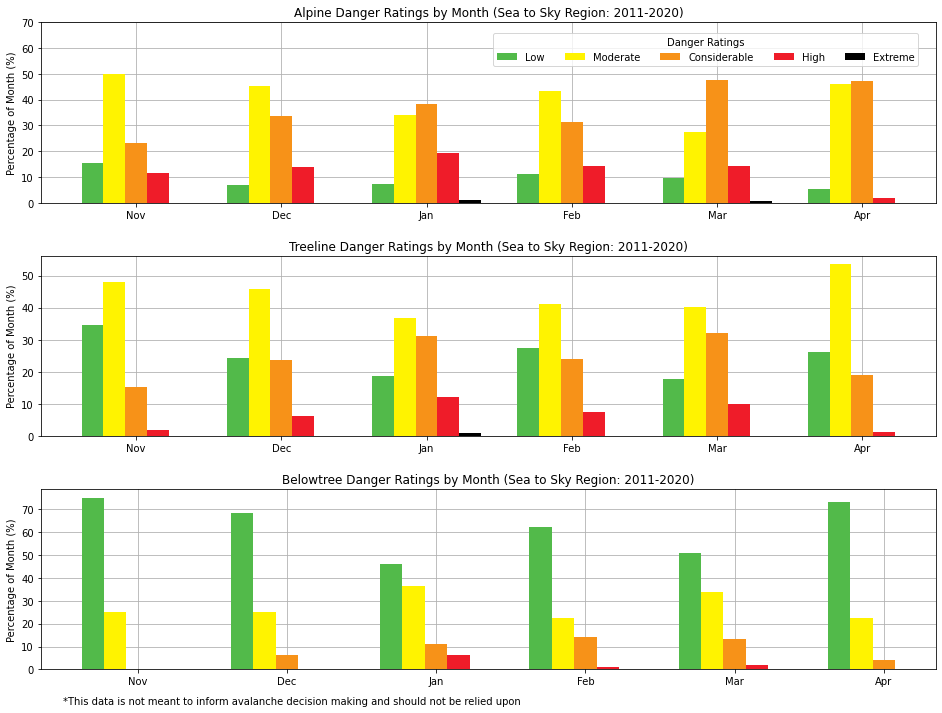

In [74]:
# list of months in dataset
months = [11, 12, 1, 2, 3, 4]

# initialize empty lists
alpine_conditions = []
treeline_conditions = []
belowtree_conditions = []
year_labels = []

for month in months:
    
    # creates list of avalanche danger ratins for each month at each elevation
    alpine_conditions.append(df_cleaned_current[df_cleaned_current.date_valid.dt.month == month]
                             ['alpine_status_code'].value_counts(normalize=True) * 100)
    
    treeline_conditions.append(df_cleaned_current[df_cleaned_current.date_valid.dt.month == month]
                             ['treeline_status_code'].value_counts(normalize=True) * 100)
        
    belowtree_conditions.append(df_cleaned_current[df_cleaned_current.date_valid.dt.month == month]
                             ['belowtree_status_code'].value_counts(normalize=True) * 100)
    
# creates dataframes from lists
df_alpine = pd.DataFrame(alpine_conditions)
df_treeline = pd.DataFrame(treeline_conditions)
df_belowtree = pd.DataFrame(belowtree_conditions)
                            
fig, ax = plt.subplots(3,1,figsize=(14,10), facecolor="white")

# define plot properties
title_label = ['Alpine', 'Treeline', 'Belowtree']
month_labels = ['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr']
x = np.arange(len(months))
width = 0.15

# create bar charts
for i, df in enumerate([df_alpine, df_treeline, df_belowtree]):
    
    rects1 = ax[i].bar(x - width*2, df[1], width, label='Low', zorder=3, color=colors[0])
    rects2 = ax[i].bar(x - width, df[2], width, label='Moderate', zorder=3, color=colors[1])
    rects3 = ax[i].bar(x, df[3], width, label='Considerable', zorder=3, color=colors[2])
    rects4 = ax[i].bar(x + width, df[4], width, label='High', zorder=3, color=colors[3])
    
    # trick to avoid plotting error when extreme doesn't exist
    if 5 in df.columns:
        rects5 = ax[i].bar(x + width*2, df[5], width, label='Extreme', zorder=3, color=colors[4])
        
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(month_labels)
    ax[i].set_title('{} Danger Ratings by Month (Sea to Sky Region: 2011-2020)'.format(title_label[i]))
    ax[i].set_ylabel('Percentage of Month (%)')
    ax[i].grid(zorder=0)
    
# legend and limits
ax[0].legend(title="Danger Ratings", loc='center left', bbox_to_anchor=(0.5, 0.6, 0.5, 0.5), ncol=5)
ax[0].set_ylim([0, 70])

fig.tight_layout(pad=2)

ax[2].text(-0.5, -15, '*This data is not meant to inform avalanche decision making and should not be relied upon')

plt.savefig('../figures/avalanche-danger-ratings-by-month-sea-to-sky-2011-2020.png')

## Data Analysis

#### Most common avalanche problems

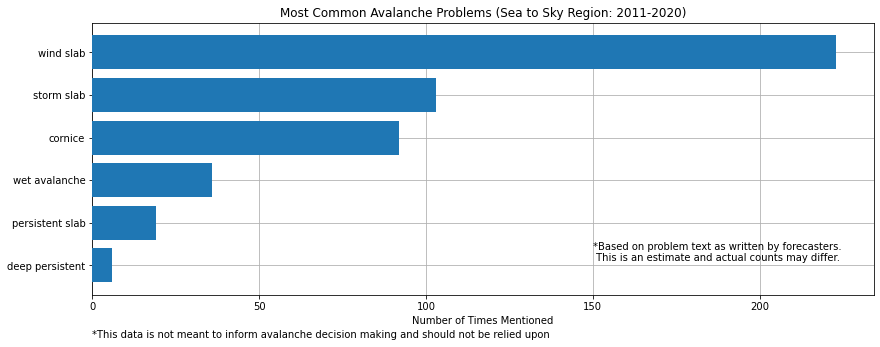

In [78]:
# types of problems to search in text based on Simon Fraser document
avy_problem_types = ['storm slab', 'wind slab', 'wet avalanche', 'cornice', 'persistent slab', 
                     'deep persistent', 'wet loose']

# initialize empty list
count = []

# loops through reported problems and matches with problem types
for problem in df_cleaned_current.problems:
    
    for avy_problem_type in avy_problem_types:
        
        if avy_problem_type in problem.lower().replace('.',''):
            count.append(avy_problem_type)
            
# creates a count of the most common problem types 
common_problem_count = pd.DataFrame(Counter(count).most_common()).sort_values(by=[1])

fig, ax = plt.subplots(1,1,figsize=(14,5), facecolor="white")

# bar plot
ax.barh(common_problem_count[0], common_problem_count[1], zorder=3)
ax.set_xlabel('Number of Times Mentioned')
ax.set_title('Most Common Avalanche Problems (Sea to Sky Region: 2011-2020)')
ax.text(150,0.1,'*Based on problem text as written by forecasters. \n This is an estimate and actual counts may differ.')
ax.grid(zorder=0)

ax.text(0, -1.7, '*This data is not meant to inform avalanche decision making and should not be relied upon')

plt.savefig('../figures/frequency-of-avalanche-problem-types-sea-to-sky-2011-2020.png')

#### Danger Rating Forecast Anomaly

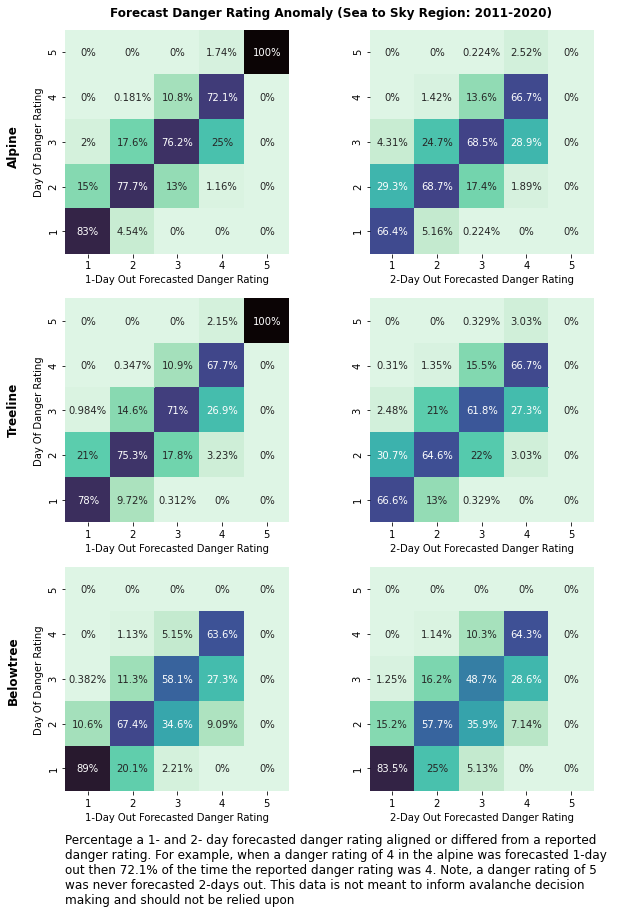

In [121]:
# merge day of and forecasted datasets
df_now_plus1 = pd.merge(df_cleaned_current, df_cleaned_current_plus1, left_on='date_valid', right_on='date_valid')
df_now_plus2 = pd.merge(df_cleaned_current, df_cleaned_current_plus2, left_on='date_valid', right_on='date_valid')

# initiate empty matrix to fill
df_alpine_now_plus1 = zero_matrix()
df_treeline_now_plus1 = zero_matrix()
df_belowtree_now_plus1 = zero_matrix()

df_alpine_now_plus2 = zero_matrix()
df_treeline_now_plus2 = zero_matrix()
df_belowtree_now_plus2 = zero_matrix()

# for each danger rating in day of conditions check frequency of forecasted danger rating across all ratings
for i in [1,2,3,4,5]:
    
    for j in [1,2,3,4,5]:
        
        alp_tmp_1 = len(df_now_plus1[(df_now_plus1.alpine_status_code_x == j) & (df_now_plus1.alpine_status_code_y == i)])
        alp_tmp_1 = (alp_tmp_1 / len(df_now_plus1[df_now_plus1.alpine_status_code_y == i])) * 100
        
        alp_tmp_2 = len(df_now_plus2[(df_now_plus2.alpine_status_code_x == j) & (df_now_plus2.alpine_status_code_y == i)])
        if i == 5:
            alp_tmp_2 = 0
        else:
            alp_tmp_2 = (alp_tmp_2 / len(df_now_plus2[df_now_plus2.alpine_status_code_y == i])) * 100
        
        treeline_tmp_1 = len(df_now_plus1[(df_now_plus1.treeline_status_code_x == j) & (df_now_plus1.treeline_status_code_y == i)])
        treeline_tmp_1 = (treeline_tmp_1 / len(df_now_plus1[df_now_plus1.treeline_status_code_y == i])) * 100
        
        treeline_tmp_2 = len(df_now_plus2[(df_now_plus2.treeline_status_code_x == j) & (df_now_plus2.treeline_status_code_y == i)])
        if i == 5:
            treeline_tmp_2 = 0
        else:
            treeline_tmp_2 = (treeline_tmp_2 / len(df_now_plus2[df_now_plus2.treeline_status_code_y == i])) * 100
        
        belowtree_tmp_1 = len(df_now_plus1[(df_now_plus1.belowtree_status_code_x == j) & (df_now_plus1.belowtree_status_code_y == i)])
        belowtree_tmp_2 = len(df_now_plus2[(df_now_plus2.belowtree_status_code_x == j) & (df_now_plus2.belowtree_status_code_y == i)])

        if i == 5:
            belowtree_tmp_1 = 0
            belowtree_tmp_2 = 0
        else:
            belowtree_tmp_1 = (belowtree_tmp_1 / len(df_now_plus1[df_now_plus1.belowtree_status_code_y == i])) * 100
            belowtree_tmp_2 = (belowtree_tmp_2 / len(df_now_plus2[df_now_plus2.belowtree_status_code_y == i])) * 100

        # store data in prealocated dataframe
        df_alpine_now_plus1[i].loc[j] = alp_tmp_1
        df_treeline_now_plus1[i].loc[j] = treeline_tmp_1
        df_belowtree_now_plus1[i].loc[j] = belowtree_tmp_1
        
        df_alpine_now_plus2[i].loc[j] = alp_tmp_2
        df_treeline_now_plus2[i].loc[j] = treeline_tmp_2
        df_belowtree_now_plus2[i].loc[j] = belowtree_tmp_2
        
# create heatmaps
df_list = [df_alpine_now_plus1, df_alpine_now_plus2, df_treeline_now_plus1, 
           df_treeline_now_plus2, df_belowtree_now_plus1, df_belowtree_now_plus2]

# labels 
labels = ['Alpine', '', 'Treeline', '', 'Belowtree', '']

fig, ax = plt.subplots(3, 2, figsize=(10,14), facecolor="white")
ax = ax.flatten()

# create heatmaps
for i, df in enumerate(df_list):

    ax[i] = sns.heatmap(df, annot=df, fmt='.3g', cmap='mako_r', cbar=False, square=True, ax=ax[i], vmin=0, vmax=100)
    
    for t in ax[i].texts: 
        t.set_text(t.get_text() + "%")
        
    if i % 2 == 0:
        ax[i].text(-1.3,3,labels[i], rotation=90, fontweight='bold', fontsize='12')
        ax[i].set_ylabel('Day Of Danger Rating')
        ax[i].set_xlabel('1-Day Out Forecasted Danger Rating')
        
    if i % 2 != 0:
        ax[i].set_xlabel('2-Day Out Forecasted Danger Rating')

ax[0].text(1, -0.3, 'Forecast Danger Rating Anomaly (Sea to Sky Region: 2011-2020)', fontweight='bold', fontsize='12')

ax[4].text(0, 7.5, "Percentage a 1- and 2- day forecasted danger rating aligned or differed from \
a reported \ndanger rating. For example, when a danger rating of 4 in the alpine was forecasted \
1-day \nout then 72.1% of the time the reported danger rating was 4. Note, a danger rating of \
5 \nwas never forecasted 2-days out. This data is not meant to inform avalanche decision \nmaking and should not be relied upon", fontsize='12')

plt.savefig('../figures/one_and_two_day_forecast_anomaly.png')